In [23]:
# =========================
# ETAPE 1 — Chargement NAB
# =========================
import pandas as pd, numpy as np, requests
from sklearn.preprocessing import StandardScaler


category = "realKnownCause"
fname    = "ambient_temperature_system_failure.csv"

# 1) Charger la série depuis GitHub
raw_csv = f"https://raw.githubusercontent.com/numenta/NAB/master/data/{category}/{fname}"
df = pd.read_csv(raw_csv)

time_candidates  = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
if not time_candidates:
    raise ValueError("Impossible de trouver la colonne temps (contient 'time' ou 'date').")
TIME_COL = time_candidates[0]
value_candidates = [c for c in df.columns if c != TIME_COL and df[c].dtype != "object"]
if not value_candidates:
    for c in df.columns:
        if c != TIME_COL:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if df[c].notna().any():
                value_candidates = [c]; break
if not value_candidates:
    raise ValueError("Impossible de trouver la colonne valeur.")
VALUE_COL = value_candidates[0]

df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df[[TIME_COL, VALUE_COL]].dropna().sort_values(TIME_COL).reset_index(drop=True)

# 2) Charger les fenêtres d'anomalies
labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
windows = requests.get(labels_url).json()
key = f"{category}/{fname}"
win_list = windows.get(key, [])

ts = df[TIME_COL].to_numpy()
labels_points = np.zeros(len(df), dtype=bool)

for w in win_list:
    if isinstance(w, dict):
        s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
    elif isinstance(w, (list, tuple)) and len(w) >= 2:
        s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
    else:
        continue
    labels_points |= (ts >= s) & (ts <= e)

df["label"] = labels_points.astype(int)
scaler = StandardScaler().fit(df.loc[df["label"]==0, [VALUE_COL]])
df["x"] = scaler.transform(df[[VALUE_COL]])

n_total = len(df)
n_anom  = int(df["label"].sum())
print(f"Série chargée: {key}")
print(f"Période: {df[TIME_COL].min()} -> {df[TIME_COL].max()} | n={n_total}")
print(f"Fenêtres NAB: {len(win_list)} | Points anormaux (NAB): {n_anom}")
display(df.head())

Série chargée: realKnownCause/ambient_temperature_system_failure.csv
Période: 2013-07-04 00:00:00 -> 2014-05-28 15:00:00 | n=7267
Fenêtres NAB: 2 | Points anormaux (NAB): 726


,timestamp,value,label,x
0,2013-07-04 00:00:00,69.880835,0,-0.336285
1,2013-07-04 01:00:00,71.220227,0,0.006880
2,2013-07-04 02:00:00,70.877805,0,-0.080852
3,2013-07-04 03:00:00,68.959400,0,-0.572366
4,2013-07-04 04:00:00,69.283551,0,-0.489316


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# reshape pour scaler : (N, 1)
values = df["value"].values.reshape(-1, 1)

values_scaled = scaler.fit_transform(values)

df["value_scaled"] = values_scaled

In [25]:
signal = df["value_scaled"].values

In [26]:
# =========================
# ETAPE 2 — Fenêtrage + masques
# =========================
import numpy as np
import pandas as pd

SEQ_LEN = 100

def to_windows(series: pd.Series, seq_len: int):
    X = []
    for i in range(len(series) - seq_len):
        X.append(series.iloc[i:i+seq_len].values.reshape(seq_len, 1))
    return np.array(X)

X_all = to_windows(df["x"], SEQ_LEN)
dates_all = df[TIME_COL].iloc[SEQ_LEN:].reset_index(drop=True)

labels_points = df["label"].astype(bool).to_numpy()
win_is_anom = np.array([
    labels_points[i:i+SEQ_LEN].any()
    for i in range(len(labels_points) - SEQ_LEN)
], dtype=bool)

idx_norm = ~win_is_anom
X_train  = X_all[idx_norm]
n_all, n_norm, n_anom = len(X_all), int(idx_norm.sum()), int((~idx_norm).sum())

print(f"Fenêtres totales : {n_all}")
print(f"   ↳ 100% normales (train) : {n_norm}")
print(f"   ↳ touchent une anomalie : {n_anom}")

print("\nVérifs de shapes :")
print("X_all :", X_all.shape, "| X_train :", X_train.shape, "| dates_all :", dates_all.shape)

Fenêtres totales : 7167
   ↳ 100% normales (train) : 6243
   ↳ touchent une anomalie : 924

Vérifs de shapes :
X_all : (7167, 100, 1) | X_train : (6243, 100, 1) | dates_all : (7167,)


In [27]:
import requests, pandas as pd

def load_anomaly_windows_for(series_relpath: str):
    """
    Retourne [(start_ts, end_ts), ...] pour une série NAB donnée,
    en gérant les items au format dict {"start","end"} OU liste ["start","end"].
    """
    labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
    windows = requests.get(labels_url).json()
    raw_list = windows.get(series_relpath, [])
    out = []
    for w in raw_list:
        if isinstance(w, dict) and "start" in w and "end" in w:
            s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
        elif isinstance(w, (list, tuple)) and len(w) >= 2:
            s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
        else:
            continue
        if e < s:
            s, e = e, s
        out.append((s, e))
    return out

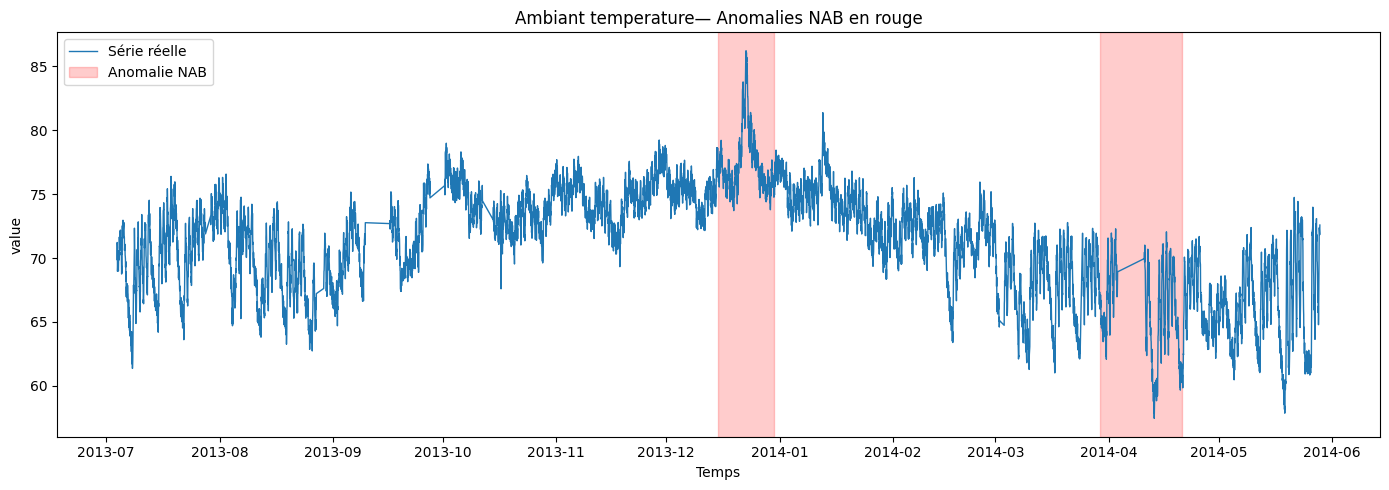

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Charger les fenêtres d'anomalies NAB pour cette série
true_ints = load_anomaly_windows_for(
    "realKnownCause/ambient_temperature_system_failure.csv"
)

plt.figure(figsize=(14, 5))
ts = df[TIME_COL]
vals = df[VALUE_COL]

plt.plot(ts, vals, lw=1, label="Série réelle")
first = True
for start, end in true_ints:
    plt.axvspan(start, end,
                color="red", alpha=0.2,
                label="Anomalie NAB" if first else None)
    first = False

plt.title("Ambiant temperature— Anomalies NAB en rouge")
plt.xlabel("Temps")
plt.ylabel(VALUE_COL)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [29]:
# ====================================
# ETAPE 3 — CNN 1D Autoencodeur
# ====================================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras import regularizers

reg_l2 = 1e-5
drop   = 0.3

inputs = Input(shape=(SEQ_LEN, 1))

# ---- ENCODEUR ----
x = Conv1D(
    filters=32,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=regularizers.l2(reg_l2)
)(inputs)

x = MaxPooling1D(pool_size=2, padding="same")(x)
x = Dropout(drop)(x)

x = Conv1D(
    filters=16,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=regularizers.l2(reg_l2)
)(x)
x = Dropout(drop)(x)

# ---- BOTTLENECK ----
bottleneck = Conv1D(
    filters=8,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=regularizers.l2(reg_l2),
    name="bottleneck_cnn"
)(x)

# ---- DECODEUR ----
x = UpSampling1D(size=2)(bottleneck)

x = Conv1D(
    filters=16,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=regularizers.l2(reg_l2)
)(x)
x = Dropout(drop)(x)

outputs = Conv1D(
    filters=1,
    kernel_size=3,
    activation="linear",
    padding="same"
)(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mae")

model.summary()
print("Input :", model.input_shape, " | Output :", model.output_shape)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 100, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 50, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_cnn (Conv1D)         │ (None, 50, 8)          │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 100, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 100, 16)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 100, 1)         │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

Input : (None, 100, 1)  | Output : (None, 100, 1)


Entraînement sur 5619 fenêtres, validation sur 624.
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.5377 - val_loss: 0.3000
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2879 - val_loss: 0.2807
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2442 - val_loss: 0.2057
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2161 - val_loss: 0.1937
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2037 - val_loss: 0.1844
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1961 - val_loss: 0.1755
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1898 - val_loss: 0.1991
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1858 - val_loss: 0.1993
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1825 - val_loss: 0.2207
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1797 - val_loss: 0.2145
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1781 - val_loss: 0.2088


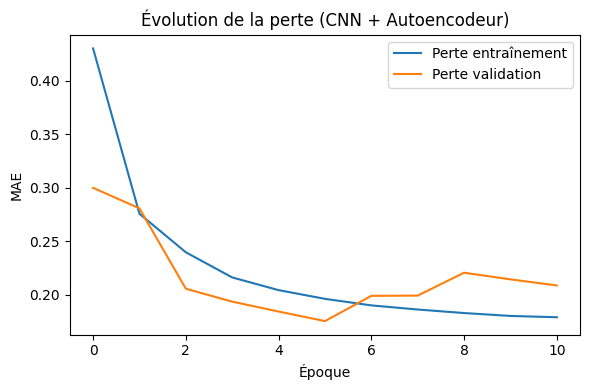

In [30]:
# =========================
# ETAPE 4 — Entraînement du modèle CNN + AE
# =========================
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# On garde les 10 % dernières fenêtres normales pour validation temporelle
val_split = 0.1
n_val = int(len(X_train) * val_split)
X_train_sub = X_train[:-n_val]
X_val_sub   = X_train[-n_val:]

print(f"Entraînement sur {len(X_train_sub)} fenêtres, validation sur {len(X_val_sub)}.")

history = model.fit(
    X_train_sub, X_train_sub,
    epochs=20,
    batch_size=64,
    shuffle=False,
    validation_data=(X_val_sub, X_val_sub),
    callbacks=[es],
    verbose=1
)

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Perte entraînement")
plt.plot(history.history["val_loss"], label="Perte validation")
plt.xlabel("Époque")
plt.ylabel("MAE")
plt.legend()
plt.title("Évolution de la perte (CNN + Autoencodeur)")
plt.tight_layout()
plt.show()

In [31]:
# =========================
#  Reconstruction
# =========================
import numpy as np
import pandas as pd

pred_all = model.predict(X_all, verbose=0).squeeze(-1)
n = len(df)

recon_sum   = np.zeros(n)
recon_count = np.zeros(n)
for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

recon = np.full(n, np.nan)
mask_valid = recon_count > 0
recon[mask_valid] = recon_sum[mask_valid] / recon_count[mask_valid]

try:
    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    orig_value  = df[VALUE_COL].to_numpy()
except Exception:
    recon_value = recon
    orig_value  = df["x"].to_numpy()

# 3) Erreur pointwise + lissage
df["recon"]      = recon_value
df["abs_err"]    = np.abs(orig_value - recon_value)
df.loc[:SEQ_LEN-2, "abs_err"] = np.nan

WIN = 7
df["err_smooth"] = (
    df["abs_err"]
    .rolling(WIN, center=True, min_periods=1).median()
    .rolling(WIN, center=True, min_periods=1).mean()
)

valid_pts = df["err_smooth"].notna().sum()
print(f"Reconstruction OK. Points valides pour l'erreur lissée : {valid_pts}/{len(df)}")
display(df[[TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].head(10))

Reconstruction OK. Points valides pour l'erreur lissée : 7174/7267


,timestamp,value,recon,abs_err,err_smooth
0,2013-07-04 00:00:00,69.880835,70.775384,NaN,NaN
1,2013-07-04 01:00:00,71.220227,70.503181,NaN,NaN
2,2013-07-04 02:00:00,70.877805,70.159196,NaN,NaN
3,2013-07-04 03:00:00,68.959400,69.860889,NaN,NaN
4,2013-07-04 04:00:00,69.283551,69.664019,NaN,NaN
5,2013-07-04 05:00:00,70.060966,69.578803,NaN,NaN
6,2013-07-04 06:00:00,69.279765,69.487380,NaN,NaN
7,2013-07-04 07:00:00,69.369608,69.421322,NaN,NaN
8,2013-07-04 08:00:00,69.166714,69.437070,NaN,NaN
9,2013-07-04 09:00:00,68.986083,69.567016,NaN,NaN


Erreur calculée pour 7174/7267 points.


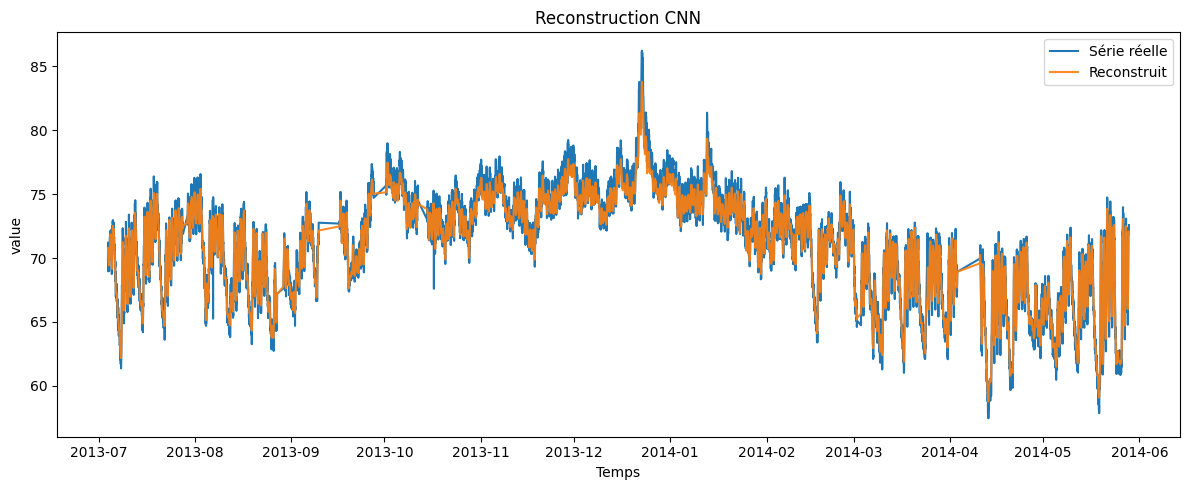

In [34]:
# =========================
# ETAPE 5 — Reconstruction + erreur pointwise
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pred_all = model.predict(X_all, verbose=0).squeeze(-1)
n = len(df)

recon_sum   = np.zeros(n)
recon_count = np.zeros(n)
for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

recon = np.full(n, np.nan)
mask = recon_count > 0
recon[mask] = recon_sum[mask] / recon_count[mask]

try:
    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    orig_value  = df[VALUE_COL].to_numpy()
except:
    recon_value = recon
    orig_value  = df.get("x", df[VALUE_COL]).to_numpy()

df["recon"]   = recon_value
df["abs_err"] = np.abs(orig_value - recon_value)

df.loc[:SEQ_LEN-2, "abs_err"] = np.nan

WIN = 7
df["err_smooth"] = (
    df["abs_err"]
      .rolling(WIN, center=True, min_periods=1).median()
      .rolling(WIN, center=True, min_periods=1).mean()
)

print(f"Erreur calculée pour {df['err_smooth'].notna().sum()}/{len(df)} points.")

def plot_reconstruction(start=None, end=None, title="Reconstruction CNN"):
    ts  = df[TIME_COL]
    ori = orig_value
    rec = recon_value

    mask = np.ones(len(df), dtype=bool)
    if start: mask &= (ts >= pd.to_datetime(start))
    if end:   mask &= (ts <= pd.to_datetime(end))

    plt.figure(figsize=(12,5))
    plt.plot(ts[mask], ori[mask], label="Série réelle")
    plt.plot(ts[mask], rec[mask], label="Reconstruit", alpha=0.9)

    if "true_intervals" in globals():
        once = True
        for s,e in true_intervals:
            if s <= ts[mask].iloc[-1] and e >= ts[mask].iloc[0]:
                plt.axvspan(s, e, alpha=0.15, color="red",
                            label="NAB" if once else None)
                once = False

    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel(VALUE_COL)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_reconstruction()

In [35]:
# =========================
# Seuils
# =========================
import numpy as np
import pandas as pd

# 1) Seuils calculés sur les points normaux uniquement
valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask
norm_err = df.loc[normal_mask_points, "err_smooth"].values

Q_HIGH, Q_LOW = 0.9999, 0.10
seuil_haut = np.quantile(norm_err, Q_HIGH)
seuil_bas  = np.quantile(norm_err, Q_LOW)
print(f"Seuils (calculés sur le normal) -> haut={seuil_haut:.4f} (Q{int(Q_HIGH*100)}), bas={seuil_bas:.4f} (Q{int(Q_LOW*100)})")

# 2) Hystérèse avec PERSISTANCE
L_up, L_down = 3, 5

err = df["err_smooth"].to_numpy()
flags = np.zeros(len(err), dtype=bool)
state = False
up_cnt = down_cnt = 0

for i, e in enumerate(err):
    if not np.isfinite(e):
        flags[i] = state
        continue
    if not state:
        if e > seuil_haut:
            up_cnt += 1
            if up_cnt >= L_up:
                state = True
                down_cnt = 0
        else:
            up_cnt = 0
    else:
        if e < seuil_bas:
            down_cnt += 1
            if down_cnt >= L_down:
                state = False
                up_cnt = 0
        else:
            down_cnt = 0
    flags[i] = state

y_true = (df["label"].values == 1) & valid_mask
y_pred = flags & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))
n_true = int(np.sum(y_true))
n_pred = int(np.sum(y_pred))
n_total = int(np.sum(valid_mask))

precision = TP / (TP + FP) if (TP+FP) else 0.0
recall    = TP / (TP + FN) if (TP+FN) else 0.0
f1        = 2*precision*recall / (precision+recall) if (precision+recall) else 0.0

print("\n📊 Comptes point-par-point :")
print(f"- Points valides                : {n_total}")
print(f"- VRAIS points anormaux (NAB)   : {n_true}")
print(f"- Points détectés par le LSTM   : {n_pred}")
print(f"   ↳ Vrais positifs (TP)        : {TP}")
print(f"   ↳ Faux positifs (FP)         : {FP}")
print(f"   ↳ Faux négatifs (FN)         : {FN}")
print(f"   ↳ Vrais négatifs (TN)        : {TN}")
print(f"\nMetrics : Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")


detected_points = df.loc[y_pred, [TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].rename(
    columns={TIME_COL: "timestamp", VALUE_COL: "value"}
)
print("\n🕒 Aperçu des points détectés (les 15 premiers) :")
display(detected_points.head(15))

out_path = "detected_points.csv"
detected_points.to_csv(out_path, index=False)
print(f"\n💾 Exporté : {out_path}  (timestamps + valeurs + erreurs)")

Seuils (calculés sur le normal) -> haut=1.1577 (Q99), bas=0.2686 (Q10)

📊 Comptes point-par-point :
- Points valides                : 7174
- VRAIS points anormaux (NAB)   : 726
- Points détectés par le LSTM   : 304
   ↳ Vrais positifs (TP)        : 206
   ↳ Faux positifs (FP)         : 98
   ↳ Faux négatifs (FN)         : 520
   ↳ Vrais négatifs (TN)        : 6443

Metrics : Precision=0.678 | Recall=0.284 | F1=0.400

🕒 Aperçu des points détectés (les 15 premiers) :


,timestamp,value,recon,abs_err,err_smooth
3697,2013-12-21 20:00:00,82.289240,80.347581,1.941659,1.555489
3698,2013-12-21 21:00:00,82.989869,80.897013,2.092856,1.630242
3699,2013-12-21 22:00:00,83.247886,81.155910,2.091977,1.694429
3700,2013-12-21 23:00:00,82.519659,81.214556,1.305103,1.738654
3701,2013-12-22 00:00:00,82.736802,81.268890,1.467912,1.784578
3702,2013-12-22 01:00:00,83.780995,81.333928,2.447066,1.828537
3703,2013-12-22 02:00:00,83.008634,81.244892,1.763741,1.803120
3704,2013-12-22 03:00:00,82.815627,80.977924,1.837703,1.779401
3705,2013-12-22 04:00:00,81.774744,80.727158,1.047586,1.761185
3706,2013-12-22 05:00:00,82.454278,80.526316,1.927962,1.762883



💾 Exporté : detected_points.csv  (timestamps + valeurs + erreurs)


In [36]:
import requests, pandas as pd

def load_anomaly_windows_for(series_relpath: str):
    """
    Retourne [(start_ts, end_ts), ...] pour une série NAB donnée,
    en gérant les items au format dict {"start","end"} OU liste ["start","end"].
    """
    labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
    windows = requests.get(labels_url).json()
    raw_list = windows.get(series_relpath, [])
    out = []
    for w in raw_list:
        if isinstance(w, dict) and "start" in w and "end" in w:
            s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
        elif isinstance(w, (list, tuple)) and len(w) >= 2:
            s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
        else:
            continue
        if e < s:
            s, e = e, s
        out.append((s, e))
    return out

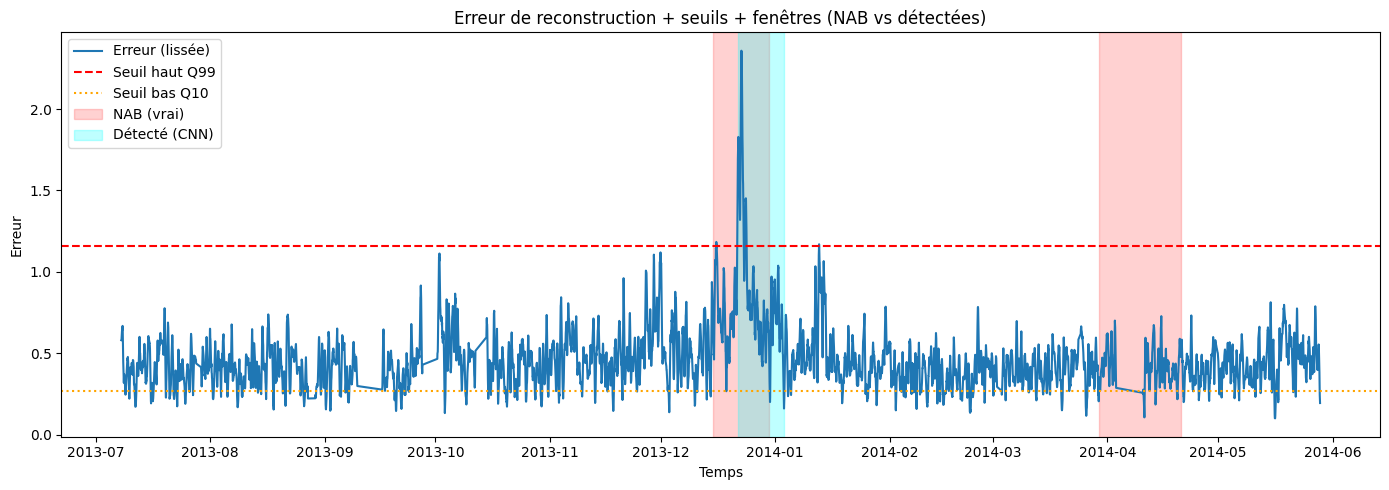

Fenêtres NAB : [(Timestamp('2013-12-15 07:00:00'), Timestamp('2013-12-30 09:00:00')), (Timestamp('2014-03-29 15:00:00'), Timestamp('2014-04-20 22:00:00'))]
Fenêtres détectées : [(Timestamp('2013-12-21 20:00:00'), Timestamp('2014-01-03 12:00:00'))] ... (total 1 )


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# reconstruit les intervalles à partir des flags booléens
def flags_to_intervals(flags, dates):
    ints = []
    on = False
    start = None
    for i in range(1, len(flags)):
        if flags[i] and not flags[i-1]:
            on = True; start = dates.iloc[i]
        if not flags[i] and flags[i-1]:
            on = False; ints.append((start, dates.iloc[i]))
    if on:  # si ça finit en anomalie
        ints.append((start, dates.iloc[-1]))
    return ints

detected_ints = flags_to_intervals(flags, df[TIME_COL])
true_ints = load_anomaly_windows_for("realKnownCause/ambient_temperature_system_failure.csv")

plt.figure(figsize=(14,5))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1.5, label="Erreur (lissée)")
plt.axhline(seuil_haut, color="r", ls="--", label=f"Seuil haut Q{int(Q_HIGH*100)}")
plt.axhline(seuil_bas,  color="orange", ls=":", label=f"Seuil bas Q{int(Q_LOW*100)}")


lab_done = False
for s,e in true_ints:
    plt.axvspan(s, e, color="red", alpha=0.18, label=None if lab_done else "NAB (vrai)")
    lab_done = True


lab_done = False
for s,e in detected_ints:
    plt.axvspan(s, e, color="cyan", alpha=0.25, label=None if lab_done else "Détecté (CNN)")
    lab_done = True

plt.title("Erreur de reconstruction + seuils + fenêtres (NAB vs détectées)")
plt.xlabel("Temps"); plt.ylabel("Erreur")
plt.legend(loc="upper left")
plt.tight_layout(); plt.show()

print("Fenêtres NAB :", true_ints)
print("Fenêtres détectées :", detected_ints[:5], "... (total", len(detected_ints), ")")